In [257]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams['animation.html'] = 'html5'
import time

In [258]:
# define some boiler plate
nx = 10
ny = 10
# dt = 1.0e-3 # timestep size
ν = 1.46e-05 # dynamic viscosity
lx = 10
ly = 10
dx = lx/nx
dy = ly/ny
t = 2

# cell centered coordinates
xx = np.linspace(dx/2.0,lx - dx/2.0,nx, endpoint=True)
yy = np.linspace(dy/2.0,ly - dy/2.0,ny, endpoint=True)
xcc, ycc = np.meshgrid(xx,yy)

# x-staggered coordinates
xxs = np.linspace(0,lx,nx+1, endpoint=True)
xu,yu = np.meshgrid(xxs, yy)

# y-staggered coordinates
yys = np.linspace(0,ly,ny+1, endpoint=True)
xv,yv = np.meshgrid(xx, yys)

Ul = 100 #Left velocity BC
Ur = 0
Ut = 0
Ub = 0
Vl = 0
Vr = 0

#print('Reynolds Number:', Ut*lx/ν)
print('Reynolds Number:', Ul*lx/ν)
#dt = min(0.25*dx*dx/ν, 4.0*ν/Ut/Ut)
dt = min(0.25*dx*dx/ν, 4.0*ν/Ul/Ul)
print('dt=', dt)

# initialize velocities - we stagger everything in the negative direction. A scalar cell owns its minus face, only.
# Then, for example, the u velocity field has a ghost cell at x0 - dx and the plus ghost cell at lx
u = np.zeros([ny+2, nx+2]) # include ghost cells

# # same thing for the y-velocity component
v = np.zeros([ny +2, nx+2]) # include ghost cells

ut = np.zeros_like(u)
vt = np.zeros_like(u)    

# initialize the pressure
p = np.zeros([nx+2,ny+2]); # include ghost cells

# a bunch of lists for animation purposes
usol=[]
usol.append(u)

vsol=[]
vsol.append(v)

psol = []
psol.append(p)

Reynolds Number: 68493150.6849315
dt= 5.8400000000000005e-09


In [259]:
# build pressure coefficient matrix
Ap = np.zeros([ny+2,nx+2])
Ae = 1.0/dx/dx*np.ones([ny+2,nx+2])
As = 1.0/dy/dy*np.ones([ny+2,nx+2])
An = 1.0/dy/dy*np.ones([ny+2,nx+2])
Aw = 1.0/dx/dx*np.ones([ny+2,nx+2])
# set left wall coefs
Aw[1:-1,1] = 0.0
# set right wall coefs
Ae[1:-1,-2] = 0.0
# set top wall coefs
An[-2,1:-1] = 0.0
# set bottom wall coefs
As[1,1:-1] = 0.0
Ap = -(Aw + Ae + An + As)

def pressure_poisson2(p, b, dx, dy):
    pn = np.empty_like(p)
    it = 1000
    err = 1e5
    tol = 1e-8
    maxit = 500
    β = 1.1
    while err > tol and it < maxit:
        pn = p.copy()    
        for i in range(1,nx):
            for j in range(1,ny):
                ap = Ap[j,i]
                an = An[j,i]
                aso = As[j,i]
                ae = Ae[j,i]
                aw = Aw[j,i]
                rhs = b[j,i] - 1.0*(ae*p[j,i+1] + aw*p[j,i-1] + an*p[j+1,i] + aso*p[j-1,i])
                p[j,i] = β*rhs/ap + (1-β)*p[j,i]
        err = np.linalg.norm(p - pn)
        it += 1
#     print('Poisson Error:', err)        
    return p, err

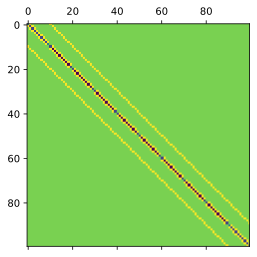

In [260]:

# USE sparse solver
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
# build pressure coefficient matrix
Ap = np.zeros([ny,nx])
Ae = 1.0/dx/dx*np.ones([ny,nx])
As = 1.0/dy/dy*np.ones([ny,nx])
An = 1.0/dy/dy*np.ones([ny,nx])
Aw = 1.0/dx/dx*np.ones([ny,nx])
# set left wall coefs
Aw[:,0] = 0.0
# set right wall coefs
Ae[:,-1] = 0.0
# set top wall coefs
An[-1,:] = 0.0
# set bottom wall coefs
As[0,:] = 0.0
Ap = -(Aw + Ae + An + As)

n = nx*ny
d0 = Ap.reshape(n)
# print(d0)
de = Ae.reshape(n)[:-1]
# print(de)
dw = Aw.reshape(n)[1:]
# print(dw)
ds = As.reshape(n)[nx:]
# print(ds)
dn = An.reshape(n)[:-nx]
# print(dn)
A1 = scipy.sparse.diags([d0, de, dw, dn, ds], [0, 1, -1, nx, -nx], format='csr')
plt.matshow((A1.toarray()))

In [261]:
# while t < tend:
t0 = time.process_time()

momtime = 0.0
solvertime = 0.0
nsteps = 10
for n in range(0,nsteps):
    
    # left wall
    #u[1:-1,1] = 0.0
    u[1:-1,1] = 2.0*Ul 
    # right wall
    u[1:-1,-1] = 2.0*Ur - u[1,2:]
    # top wall
    u[-1,1:] = 2.0*Ut - u[-2,1:]
    # bottom wall
    u[0,1:] = 2.0*Ub - u[1,1:]

    # left wall
    v[1:,0] = 2.0*Vl - v[1:,1]
    # right wall
    v[1:,-1] = 2.0*Vr - v[1:,-2]
    # bottom wall
    v[1,1:-1] = 0.0
    # top wall
    v[-1,1:-1] = 0.0    
    
    # do x-momentum first - u is of size (nx + 2) x (ny + 2) - only need to do the interior points
    tic = time.process_time()

    for i in range(2,nx+1):
        for j in range(1,ny+1):
            ue = 0.5*(u[j,i+1] + u[j,i])
            uw = 0.5*(u[j,i]   + u[j,i-1])    
            
            un = 0.5*(u[j+1,i] + u[j,i])
            us = 0.5*(u[j,i] + u[j-1,i])            
            
            vn = 0.5*(v[j+1,i] + v[j+1,i-1])
            vs = 0.5*(v[j,i] + v[j,i-1])
            
            # convection = - d(uu)/dx - d(vu)/dy
            convection = - (ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy
            
            # diffusion = d2u/dx2 + d2u/dy2
            diffusion = ν*( (u[j,i+1] - 2.0*u[j,i] + u[j,i-1])/dx/dx + (u[j+1,i] - 2.0*u[j,i] + u[j-1,i])/dy/dy )
            
            ut[j,i] = u[j,i] + dt *(convection + diffusion)
                
    # do y-momentum - only need to do interior points
    for i in range(1,nx+1):
        for j in range(2,ny+1):
            ve = 0.5*(v[j,i+1] + v[j,i])
            vw = 0.5*(v[j,i] + v[j,i-1])    
            
            ue = 0.5*(u[j,i+1] + u[j-1,i+1])
            uw = 0.5*(u[j,i] + u[j-1,i])
            
            vn = 0.5*(v[j+1,i] + v[j,i])
            vs = 0.5*(v[j,i] + v[j-1,i])            

            # convection = d(uv)/dx + d(vv)/dy
            convection = - (ue*ve - uw*vw)/dx - (vn*vn - vs*vs)/dy
            
            # diffusion = d2u/dx2 + d2u/dy2
            diffusion = ν*((v[j,i+1] - 2.0*v[j,i] + v[j,i-1])/dx/dx + (v[j+1,i] - 2.0*v[j,i] + v[j-1,i])/dy/dy)
            
            vt[j,i] = v[j,i] + dt*(convection + diffusion)            
    # do pressure - prhs = 1/dt * div(uhat)
    # we will only need to fill the interior points. This size is for convenient indexing
    divut = np.zeros([ny+2,nx+2]) 
#     for i in range(1,nx+1):
#         for j in range(1,ny+1):
#             divutilde[j,i] = (ut[j,i+1] - ut[j,i])/dx + (vt[j+1,i] - vt[j,i])/dy
    divut[1:-1,1:-1] = (ut[1:-1,2:] - ut[1:-1,1:-1])/dx + (vt[2:,1:-1] - vt[1:-1,1:-1])/dy

    prhs = 1.0/dt * divut
    toc = time.process_time()

    momtime += (toc - tic)


In [262]:
###### Use the sparse linear solver
tic=time.process_time()
#     pt = scipy.sparse.linalg.spsolve(A1,prhs[1:-1,1:-1].ravel()) #theta=sc.linalg.solve_triangular(A,d)
pt,info = scipy.sparse.linalg.bicg(A1,prhs[1:-1,1:-1].ravel(),tol=1e-10) #theta=sc.linalg.solve_triangular(A,d)
toc=time.process_time()

solvertime += toc - tic
p = np.zeros([ny+2,nx+2])
p[1:-1,1:-1] = pt.reshape([ny,nx])

    # time advance
u[1:-1,2:-1] = ut[1:-1,2:-1] - dt * (p[1:-1,2:-1] - p[1:-1,1:-2])/dx
v[2:-1,1:-1] = vt[2:-1,1:-1] - dt * (p[2:-1,1:-1] - p[1:-2,1:-1])/dy   


total time 0.171875 s
time per timestep = 0.0171875 s
mom assembly time 0.171875 s
solver time 0.0 s
solver fraction = 0.0 %


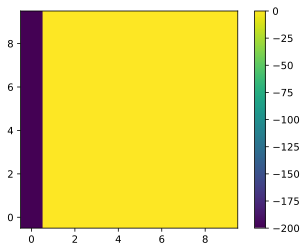

In [263]:
t += dt
tend = time.process_time()

totaltime = tend - t0
print('total time', totaltime, 's')
print('time per timestep =',totaltime/nsteps, 's')
print('mom assembly time', totaltime - solvertime, 's')
print('solver time', solvertime, 's')
print('solver fraction =', np.ceil(solvertime/(tend - t0)*100),'%')


divu = (u[1:-1,2:] - u[1:-1,1:-1])/dx + (v[2:,1:-1] - v[1:-1,1:-1])/dy
plt.imshow(divu,origin='lower')
plt.colorbar()

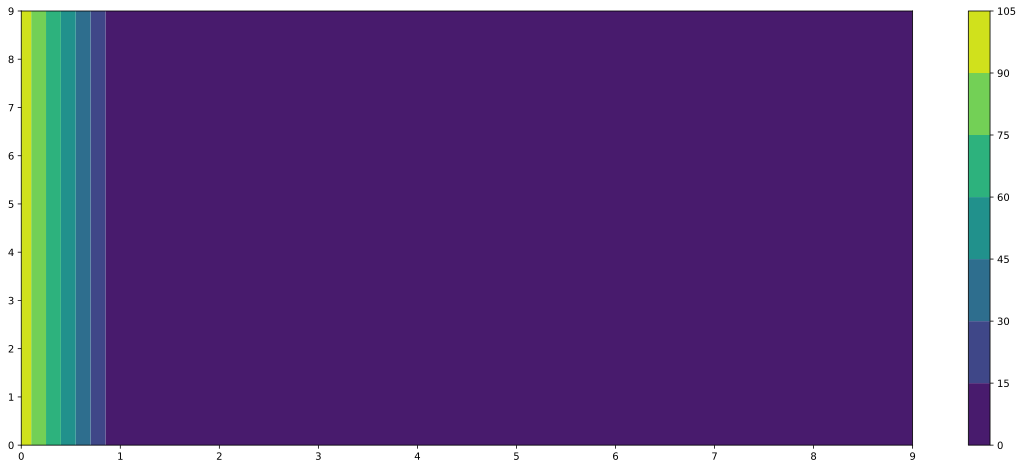

In [264]:
#Velocity contour
fig = plt.figure(figsize=[20,8],dpi=600)
ucc = 0.5*(u[1:-1,2:] + u[1:-1,1:-1])
vcc = 0.5*(v[2:,1:-1] + v[1:-1,1:-1])
speed = np.sqrt(ucc*ucc + vcc*vcc)
plt.contourf(speed)
plt.colorbar()

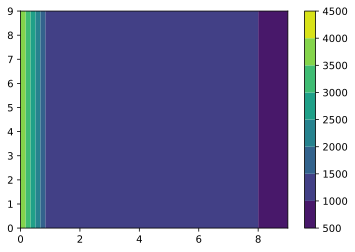

In [265]:
#Pressure contour
pu = 0.5*(p[1:-1,2:] + p[1:-1,1:-1])
pv = 0.5*(p[2:,1:-1] + p[1:-1,1:-1])
rp = np.sqrt(pu*pu + pv-pv)
plt.contourf(rp)
plt.colorbar()